In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.regularizers import l2
import string
import pickle
import tensorflow as tf

In [2]:
# Baca data
data_emosi = pd.read_csv('Data/emotion_sentimen_dataset.csv')
data_emosi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839555 entries, 0 to 839554
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  839555 non-null  int64 
 1   text        839555 non-null  object
 2   Emotion     839555 non-null  object
dtypes: int64(1), object(2)
memory usage: 19.2+ MB


In [3]:
data_emosi.describe()

,Unnamed: 0
count,839555.000000
mean,419777.000000
std,242358.796962
min,0.000000
25%,209888.500000
50%,419777.000000
75%,629665.500000
max,839554.000000


In [4]:
data_emosi.shape

(839555, 3)

In [5]:
data_emosi.columns

Index(['Unnamed: 0', 'text', 'Emotion'], dtype='object')

In [6]:
data_emosi.Emotion.value_counts()

Emotion
neutral       674538
love           39553
happiness      27175
sadness        17481
relief         16729
hate           15267
anger          12336
fun            10075
enthusiasm      9304
surprise        6954
empty           5542
worry           4475
boredom          126
Name: count, dtype: int64

In [7]:
# Filter data to remove rows with "boredom" emotion
data_emosi = data_emosi[data_emosi['Emotion'] != 'boredom']
max_data_per_emotion = 10000
data_emosi_new = data_emosi.groupby('Emotion').head(max_data_per_emotion)

# Simpan DataFrame yang telah difilter kembali ke file CSV
data_emosi_new.to_csv("Data/data_emosi_new.csv", index=False)
data_emosi_new.info()

data_emosi_new.describe()
data_emosi = data_emosi_new

<class 'pandas.core.frame.DataFrame'>
Index: 106275 entries, 0 to 839531
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  106275 non-null  int64 
 1   text        106275 non-null  object
 2   Emotion     106275 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.2+ MB


In [8]:
# Drop baris dengan nilai yang hilang
data_emosi = data_emosi.dropna()

In [9]:
# Preprocessing Data
# Pisahkan kolom teks dan emosi sebagai fitur dan label
X = data_emosi['text']
y = data_emosi['Emotion']

In [10]:
# Preprocessing tambahan
# Menghapus tanda baca
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

In [11]:
# Lematisasi
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(w) for w in word_tokenize(text)])

# Menghapus angka
def remove_numbers(text):
    return ''.join([i for i in text if not i.isdigit()])

In [12]:
# Menghapus stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    return ' '.join([word for word in word_tokenize(text) if word.lower() not in stop_words])

# Preprocessing teks
def preprocess_text(text):
    text = remove_punctuation(text)
    text = lemmatize_text(text)
    text = remove_numbers(text)
    text = remove_stopwords(text)
    return text

X = X.apply(preprocess_text)

In [13]:
# Tokenisasi teks setelah preprocessing tambahan
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq)

# Encoding label
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [14]:
# Pembagian Data
X_train, X_val, y_train, y_val = train_test_split(X_pad, y_encoded, test_size=0.2, random_state=42)

In [15]:
# Model Building
num_classes = len(np.unique(y_train))  # Mengambil jumlah kelas dari data pelatihan
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=X_pad.shape[1]))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.001)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [16]:
# Model Compilation
optimizer = Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [17]:
# Callbacks
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.95 and logs.get('val_accuracy') > 0.95:
            #self.model.stop_training = True
            print("\nThe accuracy of the training set and the validation set has reached > 95%!")

callbacks = myCallback()

In [18]:
# Training Model
history = model.fit(X_train, y_train, batch_size=64, epochs=10, 
                    validation_data=(X_val, y_val), verbose=2, callbacks=[callbacks])

Epoch 1/10


1329/1329 - 342s - loss: 0.6644 - accuracy: 0.8236 - val_loss: 0.4229 - val_accuracy: 0.9252 - 342s/epoch - 258ms/step
Epoch 2/10

The accuracy of the training set and the validation set has reached > 95%!
1329/1329 - 332s - loss: 0.1676 - accuracy: 0.9786 - val_loss: 0.1029 - val_accuracy: 0.9897 - 332s/epoch - 250ms/step
Epoch 3/10

The accuracy of the training set and the validation set has reached > 95%!
1329/1329 - 330s - loss: 0.0811 - accuracy: 0.9912 - val_loss: 0.0874 - val_accuracy: 0.9891 - 330s/epoch - 249ms/step
Epoch 4/10

The accuracy of the training set and the validation set has reached > 95%!
1329/1329 - 344s - loss: 0.0647 - accuracy: 0.9932 - val_loss: 0.0627 - val_accuracy: 0.9938 - 344s/epoch - 259ms/step
Epoch 5/10

The accuracy of the training set and the validation set has reached > 95%!
1329/1329 - 349s - loss: 0.0533 - accuracy: 0.9944 - val_loss: 0.0637 - val_accuracy: 0.9936 - 349s/epoch - 263ms/step
Epoch 6/10

The accuracy of the training set

In [19]:
# Export label encoder
with open("Model/label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

# Export the trained model
model.save("Model/emotion_det.h5")

# Save the tokenizer
with open("Model/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
print("Model, tokenizer, dan label encoder telah disimpan di path /Model.")

D:\Program Files\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model, tokenizer, dan label encoder telah disimpan di path /Model.


In [20]:
# Evaluasi Model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, val_acc = model.evaluate(X_val, y_val, verbose=0)

print("Training Accuracy: {:.4f}".format(train_acc))
print("Validation Accuracy: {:.4f}".format(val_acc))

Training Accuracy: 0.9997
Validation Accuracy: 0.9961


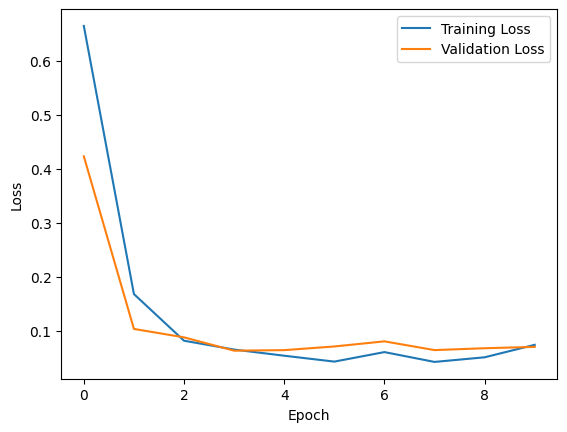

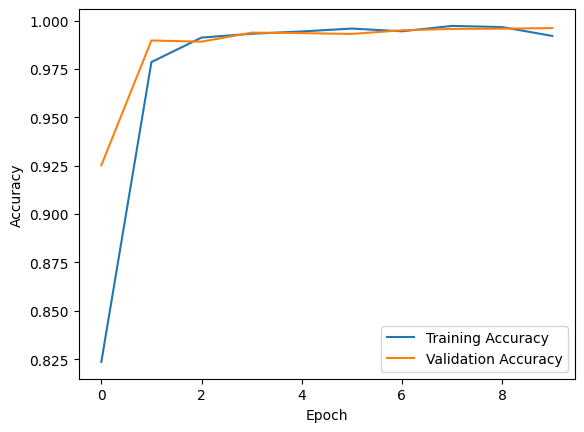

In [21]:
# Plot loss dan akurasi
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [24]:
# Fungsi untuk melakukan prediksi pada kalimat uji
def predict_emotion(test_sentence):
    test_sentence = preprocess_text(test_sentence)
    test_sequence = tokenizer.texts_to_sequences([test_sentence])
    test_sequence_pad = pad_sequences(test_sequence, maxlen=X_pad.shape[1])
    predicted_class = np.argmax(model.predict(test_sequence_pad), axis=-1)
    predicted_emotion = label_encoder.inverse_transform(predicted_class)[0]
    return predicted_emotion

# Prepare simple test sentences and their expected emotions
simple_test_sentences = [
    "I feel happy.",
    "I felt joyful.",
    "It makes me content.",
    "She is anger.",
    "I had so much fun."
]
simple_expected_emotions = ['happiness', 'fun', 'happiness', 'anger', 'fun']

# Prepare complex test sentences and their expected emotions
complex_test_sentences = [
    "I'm feeling a bit worried.",
    "I'm feeling very enthusiastic.",
    "I'm feeling extremely tired.",
    "My sister surprised me yesterday.",
    "I love you so much."
]
complex_expected_emotions = ['worry', 'enthusiasm', 'tired', 'surprise', 'love']

# Check predictions for simple test sentences
correct_predictions_simple = 0
for i, sentence in enumerate(simple_test_sentences):
    predicted_emotion = predict_emotion(sentence)
    if predicted_emotion == simple_expected_emotions[i]:
        correct_predictions_simple += 1
    else:
        print(f"Simple Test {i+1}: Expected emotion '{simple_expected_emotions[i]}' but got '{predicted_emotion}'")

# Check predictions for complex test sentences
correct_predictions_complex = 0
for i, sentence in enumerate(complex_test_sentences):
    predicted_emotion = predict_emotion(sentence)
    if predicted_emotion == complex_expected_emotions[i]:
        correct_predictions_complex += 1
    else:
        print(f"Complex Test {i+1}: Expected emotion '{complex_expected_emotions[i]}' but got '{predicted_emotion}'")

# Calculate accuracy for simple and complex test sentences
accuracy_simple = correct_predictions_simple / len(simple_test_sentences)
accuracy_complex = correct_predictions_complex / len(complex_test_sentences)

# Print result for simple test sentences
if accuracy_simple == 1.0:
    print("All simple tests passed")
else:
    print(f"Simple Test Accuracy: {accuracy_simple * 100:.2f}%")

# Print result for complex test sentences
if accuracy_complex == 1.0:
    print("All complex tests passed")
else:
    print(f"Complex Test Accuracy: {accuracy_complex * 100:.2f}%")


1/1 [==============================] - 0s 50ms/step
Simple Test 4: Expected emotion 'anger' but got 'neutral'
1/1 [==============================] - 0s 50ms/step
Complex Test 1: Expected emotion 'worry' but got 'neutral'
1/1 [==============================] - 0s 48ms/step
Complex Test 3: Expected emotion 'tired' but got 'neutral'
1/1 [==============================] - 0s 45ms/step
Simple Test Accuracy: 80.00%
Complex Test Accuracy: 60.00%
